In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
import torch
import torch.nn as nn
import sys
import pysindy as ps
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.integrate import odeint


np.random.seed(34)
warnings.filterwarnings('ignore')

sindyauto_path = '/home/sihoon/works/HAVOK/SindyAutoencoders_master/src'
if sindyauto_path not in sys.path:
    sys.path.insert(0, sindyauto_path)
from sindy_utils import library_size
from training import train_network
import tensorflow as tf


Data preparation

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names


dataset_path = './../Dataset/CMaps'

dftrain = pd.read_csv(os.path.join(dataset_path, 'train_FD001.txt'),sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv(os.path.join(dataset_path, 'test_FD001.txt'),sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv(os.path.join(dataset_path, 'RUL_FD001.txt'),sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape

train = dftrain.copy()
valid = dfvalid.copy()

print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (20631, 26)
Shape of the validation dataset :  (13096, 26)
Percentage of the validation dataset :  0.3882942449669404


Max time cycle found for each unit

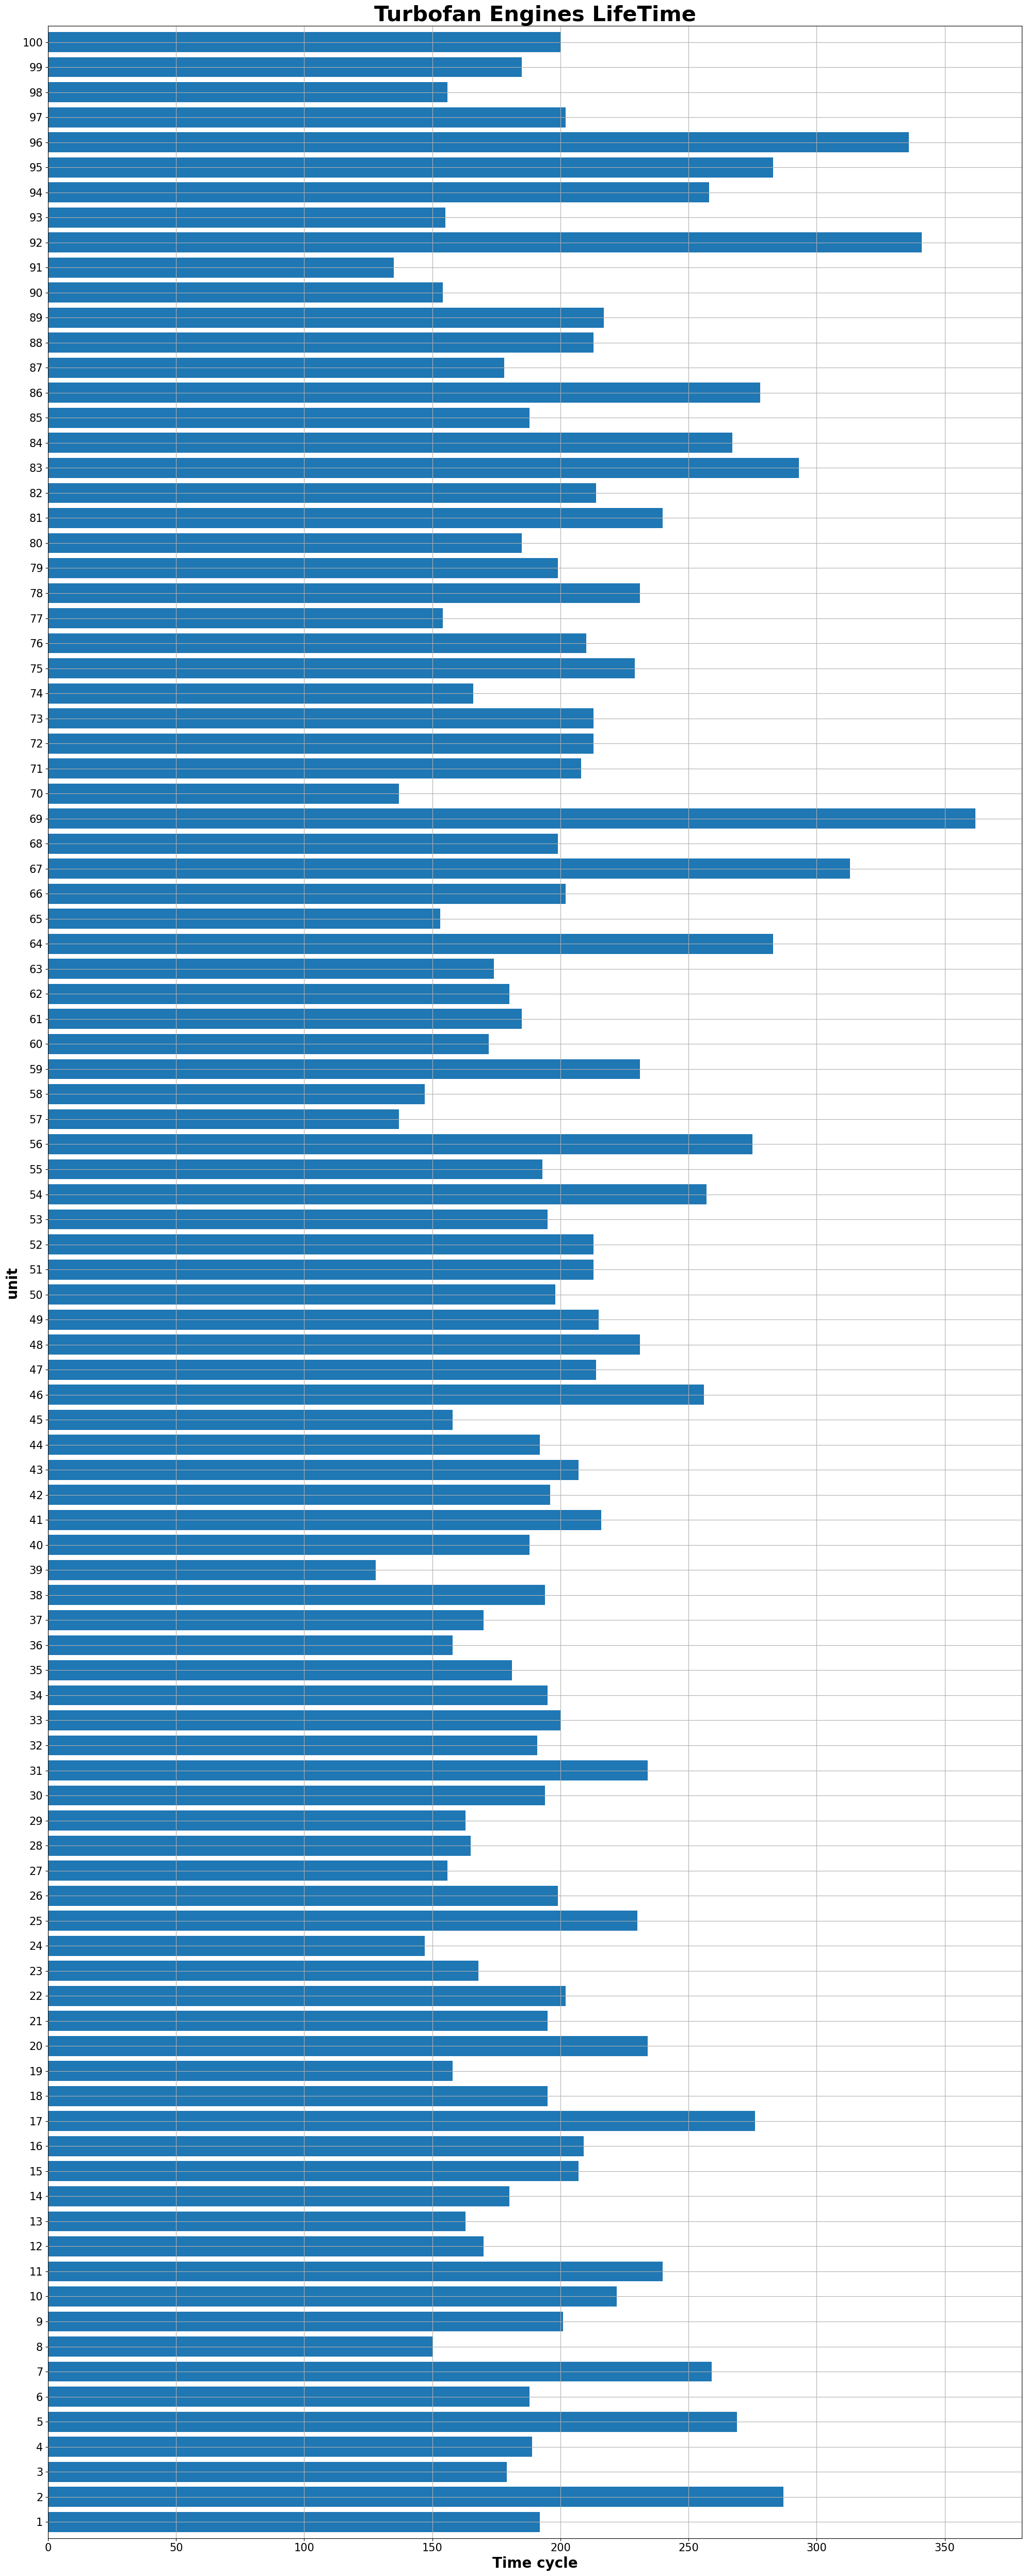

In [3]:
max_time_cycles=train[index_names].groupby('unit_number').max()
max_time_cycles
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Add RUL comun to the data
RUL corresponds to the remining time cycles for each unit before it fails

In [4]:
def add_RUL_column(df):
    '''
    RUL: for each unit_number, 'max_time_cycles' denotes end of the life time.
        Thus, RUL = 'max_time_cycles' - each currnet time 'time_cycles'
    '''
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    # print(max_time_cycles)
    # print(max_time_cycles.to_frame(name='max_time_cycle'))
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    # print(merged[['unit_number', 'max_time_cycle', 'time_cycles']])
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [5]:
train = add_RUL_column(train)
train[['unit_number','RUL']]

,unit_number,RUL
0,1,191
1,1,190
2,1,189
3,1,188
4,1,187
...,...,...
20626,100,4
20627,100,3
20628,100,2
20629,100,1


In [6]:
#Rul analysis
maxrul_u = train.groupby('unit_number').max().reset_index()
maxrul_u.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,192,0.0047,0.0005,100.0,518.67,644.21,1605.44,1432.52,14.62,...,2388.35,8140.58,8.5227,0.03,398,2388,100.0,39.18,23.4999,191
1,2,287,0.0076,0.0006,100.0,518.67,643.94,1610.10,1431.17,14.62,...,2388.26,8175.57,8.5377,0.03,398,2388,100.0,39.24,23.6005,286
2,3,179,0.0058,0.0005,100.0,518.67,643.93,1606.50,1438.51,14.62,...,2388.20,8255.34,8.5363,0.03,399,2388,100.0,39.23,23.5181,178
3,4,189,0.0059,0.0006,100.0,518.67,644.53,1612.11,1434.12,14.62,...,2388.17,8259.42,8.5462,0.03,399,2388,100.0,39.21,23.5074,188
4,5,269,0.0055,0.0005,100.0,518.67,644.02,1609.41,1434.59,14.62,...,2388.23,8215.19,8.5410,0.03,398,2388,100.0,39.29,23.5503,268


Scaling dataset


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# drop_labels = index_names+setting_names
drop_labels = index_names + ['RUL'] + setting_names
remain_labels = sensor_names

train_unit = train[train['unit_number']==1]
X_train=train.drop(columns=drop_labels).copy()
y_train = train['RUL'].copy()


X_train_scal=scaler.fit_transform(X_train)
X_train_scal_df = pd.DataFrame(X_train_scal, columns=remain_labels)


Drop constant sensors

In [8]:
# Check constant sensors
print(X_train_scal_df.iloc[:, :].describe().transpose())
const_labels = ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']
tmp_labels = drop_labels + const_labels
remain_labels = [n for n in col_names if n not in tmp_labels]
# print(remain_labels)

X_train_scal_df = X_train_scal_df.drop(columns=const_labels)
X_train_scal = X_train_scal_df.values

        count      mean       std  min       25%       50%       75%  max
s_1   20631.0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0
s_2   20631.0  0.443052  0.150618  0.0  0.335843  0.430723  0.539157  1.0
s_3   20631.0  0.424746  0.133664  0.0  0.331807  0.415522  0.508829  1.0
s_4   20631.0  0.450435  0.151935  0.0  0.339467  0.435348  0.545324  1.0
s_5   20631.0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0
s_6   20631.0  0.980321  0.138898  0.0  1.000000  1.000000  1.000000  1.0
s_7   20631.0  0.566459  0.142527  0.0  0.476651  0.578100  0.669887  1.0
s_8   20631.0  0.297957  0.107554  0.0  0.227273  0.287879  0.363636  1.0
s_9   20631.0  0.195248  0.099089  0.0  0.140761  0.174684  0.213991  1.0
s_10  20631.0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0
s_11  20631.0  0.411410  0.158981  0.0  0.297619  0.392857  0.505952  1.0
s_12  20631.0  0.580697  0.157261  0.0  0.484009  0.594883  0.695096  1.0
s_13  20631.0  0.317871  0.105763  0.0

Smooth dataset

In [9]:
from scipy.signal import savgol_filter
from mysindy_util import generate_list_increasing_by_dt

window_length = 11
poly_order = 2

X_train_scal_smoot_df = X_train_scal_df.apply(lambda col: savgol_filter(col, window_length, poly_order))
X_train_scal_smoot = X_train_scal_smoot_df.values

# Xdot
differentiation_method = ps.FiniteDifference(order=2)

# differentiation_method._differentiate(X, t)
t_max = X_train_scal_smoot.shape[0]
t = generate_list_increasing_by_dt(size=t_max, dt=1)
Xdot = differentiation_method._differentiate(X_train_scal_smoot, t)

print(X_train_scal_smoot.shape)

(20631, 15)


In [10]:
training_data = {
    't': t,
    'x': X_train_scal_smoot,
    'dx': Xdot
}
validation_data = training_data

### SINDy

In [11]:
params = {}

params['input_dim'] = len(remain_labels)
params['latent_dim'] = 8
params['model_order'] = 1
params['poly_order'] = 3
params['include_sine'] = False
params['library_dim'] = library_size(params['latent_dim'], params['poly_order'], params['include_sine'], True)

# sequential thresholding parameters
params['sequential_thresholding'] = True
params['coefficient_threshold'] = 0.1
params['threshold_frequency'] = 500
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
params['coefficient_initialization'] = 'constant'

# loss function weighting
params['loss_weight_decoder'] = 1.0
params['loss_weight_sindy_z'] = 0.0
params['loss_weight_sindy_x'] = 1e-4
params['loss_weight_sindy_regularization'] = 1e-5

params['activation'] = 'sigmoid'
params['widths'] = [64,32]

# training parameters
params['epoch_size'] = training_data['x'].shape[0]
params['batch_size'] = 1024
params['learning_rate'] = 1e-3

params['data_path'] = os.getcwd() + '/'
params['print_progress'] = True
params['print_frequency'] = 100
params['save_progress'] = True
params['save_frequency'] = 200

# training time cutoffs
params['max_epochs'] = 5001
params['refinement_epochs'] = 1001

In [12]:
import datetime

num_experiments = 1
df = pd.DataFrame()
for i in range(num_experiments):
    print('EXPERIMENT %d' % i)

    params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))

    params['save_name'] = './trained_models/cmapss_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")

    tf.reset_default_graph()
    # tf.compat.v1.get_default_graph()

    results_dict = train_network(training_data, validation_data, params)
    df = df.append({**results_dict, **params}, ignore_index=True)

df.to_pickle('experiment_results_' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.pkl')

EXPERIMENT 0



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



TRAINING




2023-08-09 14:44:00.365423: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 14:44:00.387148: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3000000000 Hz
2023-08-09 14:44:00.389335: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xbeae1e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-09 14:44:00.389378: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-09 14:44:00.389513: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 0
   training loss 0.08400481939315796, (0.0839948, 0.022689033, 0.00035373494, 0.99863964)
   validation loss 0.08234016597270966, (0.082330145, 0.021198504, 0.00034795635, 0.99863964)
decoder loss ratio: 0.323538, decoder SINDy loss  ratio: 1.067278
Epoch 100
   training loss 0.0016623864648863673, (0.0016588874, 0.099670336, 0.000430005, 0.34561095)
   validation loss 0.0017865336267277598, (0.0017830358, 0.09886481, 0.0004169401, 0.34561095)
decoder loss ratio: 0.007007, decoder SINDy loss  ratio: 1.278870
Epoch 200
   training loss 0.0009884916944429278, (0.000988454, 0.0023747687, 0.000331212, 0.00045073804)
   validation loss 0.0010796047281473875, (0.0010795675, 0.0022021485, 0.000327159, 0.00045073804)
decoder loss ratio: 0.004242, decoder SINDy loss  ratio: 1.003487
